In [1]:
from scipy.stats import pearsonr, spearmanr, norminvgauss, invgauss, expon, entropy
from sklearn.model_selection import StratifiedKFold
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from tqdm import tqdm
import copy
import pickle 
from multiprocessing import Pool

from utils import *

print(sc.__version__)

1.10.4


In [2]:
plt.rcParams['font.size'] = '18'
plt.rcParams['lines.linewidth'] = 6
plt.rcParams['lines.markersize'] = 12
plt.rcParams['figure.constrained_layout.use'] = True
label_font = '24'
legend_font = '18'
title_font = '30'

dark = 'k'

color_palette = ["#e07a5f","#3d405b","#81b29a","#f2cc8f","#98c1d9","#457b9d","#c74546","#613f75"]

from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=len(color_palette))

# Download data and preprocess

!mkdir data/Allen

!wget -P data/Allen https://zenodo.org/record/7497222/files/allen_B08_raw.loom?download=1

!wget -P data/Allen https://zenodo.org/records/7497222/files/cluster.annotation.csv

!wget -P data/Allen https://zenodo.org/records/7497222/files/cluster.membership.csv

In [3]:
adata = ad.read_loom('data/Allen/allen_B08_raw.loom',validate=False)
adata

/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 10975 × 32285
    obs: 'barcode'
    var: 'gene_id', 'gene_name'
    layers: 'matrix', 'spliced', 'unspliced'

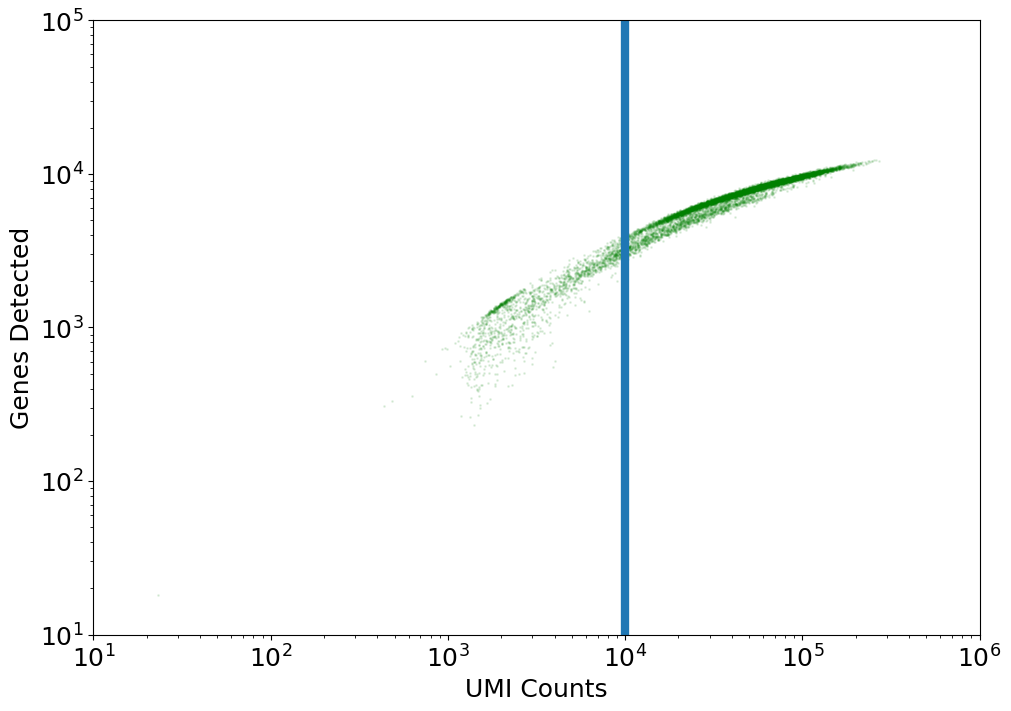

In [4]:
adata.X = adata.layers['spliced']+adata.layers['unspliced']
mtx = adata.X

fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(np.asarray(mtx.sum(axis=1)), np.asarray(np.sum(mtx>0, axis=1)), color="green", s=1, alpha=0.1)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim((10,1000000))
ax.set_ylim((10,100000))
ax.axvline(x=10000)
plt.show()

In [5]:
mtx = adata.layers['spliced']+adata.layers['unspliced']
adata = adata[np.asarray(mtx.sum(axis=1))>5000]

In [6]:
# Load the CSV files
membership_df = pd.read_csv('data/Allen/cluster.membership.csv', header=0, names=['bc', 'cluster_id'])
annotation_df = pd.read_csv('data/Allen/cluster.annotation.csv', header=0)

In [7]:
merged_df = pd.merge(membership_df, annotation_df, on='cluster_id')
merged_df['barcode']= [x[:16] for x in merged_df['bc']]
merged_df

,bc,cluster_id,cluster_label,subclass_label,class_label,cluster_color,size,barcode
0,AAACCCAAGCTTCATG-1L8TX_181211_01_G12,42,L5 IT Tcap_2,L5 IT,Glutamatergic,#52CA74,17334,AAACCCAAGCTTCATG
1,AAACCCAAGTGAGGTC-1L8TX_181211_01_G12,41,L5 IT Tcap_1,L5 IT,Glutamatergic,#5DDB65,7462,AAACCCAAGTGAGGTC
2,AAACCCACACCAGCCA-1L8TX_181211_01_G12,42,L5 IT Tcap_2,L5 IT,Glutamatergic,#52CA74,17334,AAACCCACACCAGCCA
3,AAACCCAGTGAACGGT-1L8TX_181211_01_G12,41,L5 IT Tcap_1,L5 IT,Glutamatergic,#5DDB65,7462,AAACCCAGTGAACGGT
4,AAACCCAGTGGCATCC-1L8TX_181211_01_G12,20,Vip Gpc3,Vip,GABAergic,#B09FFF,314,AAACCCAGTGGCATCC
...,...,...,...,...,...,...,...,...
94165,TTTGTTGTCAGCATTG-12L8TX_190430_01_G08,40,L2/3 IT,L2/3 IT,Glutamatergic,#6F836B,10915,TTTGTTGTCAGCATTG
94166,TTTGTTGTCATTGCGA-12L8TX_190430_01_G08,41,L5 IT Tcap_1,L5 IT,Glutamatergic,#5DDB65,7462,TTTGTTGTCATTGCGA
94167,TTTGTTGTCCCAACTC-12L8TX_190430_01_G08,43,L5 IT S100b,L5 IT,Glutamatergic,#00CF1E,4272,TTTGTTGTCCCAACTC
94168,TTTGTTGTCTATGCCC-12L8TX_190430_01_G08,42,L5 IT Tcap_2,L5 IT,Glutamatergic,#52CA74,17334,TTTGTTGTCTATGCCC


In [8]:
adata.obs['cluster_label'] = adata.obs['barcode'].map(
    lambda x: merged_df[merged_df['barcode'] == x]['cluster_label'].values[0] if x in merged_df['barcode'].values else 'Unknown'
)
adata.obs['class_label'] = adata.obs['barcode'].map(
    lambda x: merged_df[merged_df['barcode'] == x]['class_label'].values[0] if x in merged_df['barcode'].values else 'Unknown'
)

adata.obs

/tmp/ipykernel_4138257/235104793.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['cluster_label'] = adata.obs['barcode'].map(


,barcode,cluster_label,class_label
0,AAACCCAAGTACGAGC,Vip Chat_low,Low Quality
1,AAACCCAAGTGAACAT,L5 IT Tcap_2,Glutamatergic
2,AAACCCAAGTTGAATG,L2/3 IT,Glutamatergic
3,AAACCCACAAACGGCA,Unknown,Unknown
4,AAACCCACACCCTAGG,Sst Myh8_3_low,Low Quality
...,...,...,...
10969,TTTGTTGAGGGTTAAT,L6 NP Trh_low,Low Quality
10970,TTTGTTGCAAAGGATT,Sst Myh8_1,GABAergic
10971,TTTGTTGGTGAGGAAA,Sst Hpse_3,GABAergic
10972,TTTGTTGTCCAAACCA,L2/3 IT,Glutamatergic


In [9]:
adata = adata[adata.obs['cluster_label'] != 'Unknown', :]
adata = adata[adata.obs['class_label'] != 'Low Quality', :]

# View the updated adata.obs
adata.obs

,barcode,cluster_label,class_label
1,AAACCCAAGTGAACAT,L5 IT Tcap_2,Glutamatergic
2,AAACCCAAGTTGAATG,L2/3 IT,Glutamatergic
5,AAACCCACACGATAGG,L5 IT Tcap_2,Glutamatergic
6,AAACCCACAGAGGGTT,L2/3 IT,Glutamatergic
7,AAACCCAGTACTAAGA,L6 CT Cpa6_1,Glutamatergic
...,...,...,...
10968,TTTGTTGAGGGCCAAT,L2/3 IT,Glutamatergic
10970,TTTGTTGCAAAGGATT,Sst Myh8_1,GABAergic
10971,TTTGTTGGTGAGGAAA,Sst Hpse_3,GABAergic
10972,TTTGTTGTCCAAACCA,L2/3 IT,Glutamatergic


In [10]:
# Save or inspect the filtered AnnData object
adata.write('data/Allen/adata.h5ad')  # Save as .h5ad if needed
adata

/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


AnnData object with n_obs × n_vars = 6401 × 32285
    obs: 'barcode', 'cluster_label', 'class_label'
    var: 'gene_id', 'gene_name'
    layers: 'matrix', 'spliced', 'unspliced'

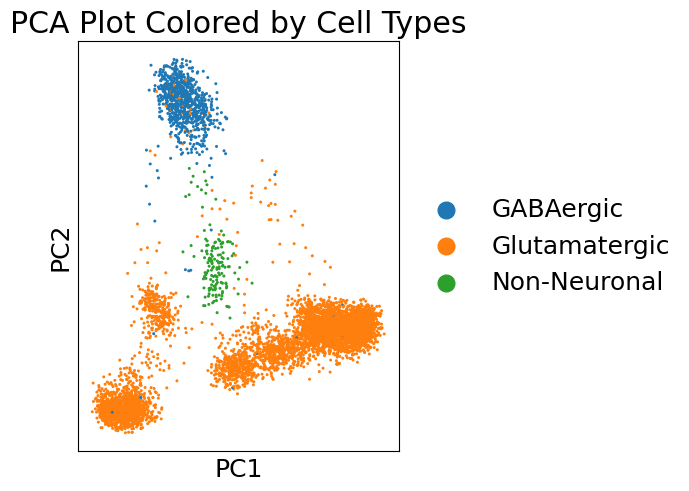

In [11]:
scdata = adata.copy()

# Normalizing to median total counts
sc.pp.normalize_total(scdata)
# Logarithmize the data
sc.pp.log1p(scdata)
sc.pp.highly_variable_genes(scdata, n_top_genes=2000)

sc.tl.pca(scdata)
sc.pl.pca(scdata, color='class_label', title="PCA Plot Colored by Cell Types")

# Calculate extrinsic noise

0.821387 0.81971204


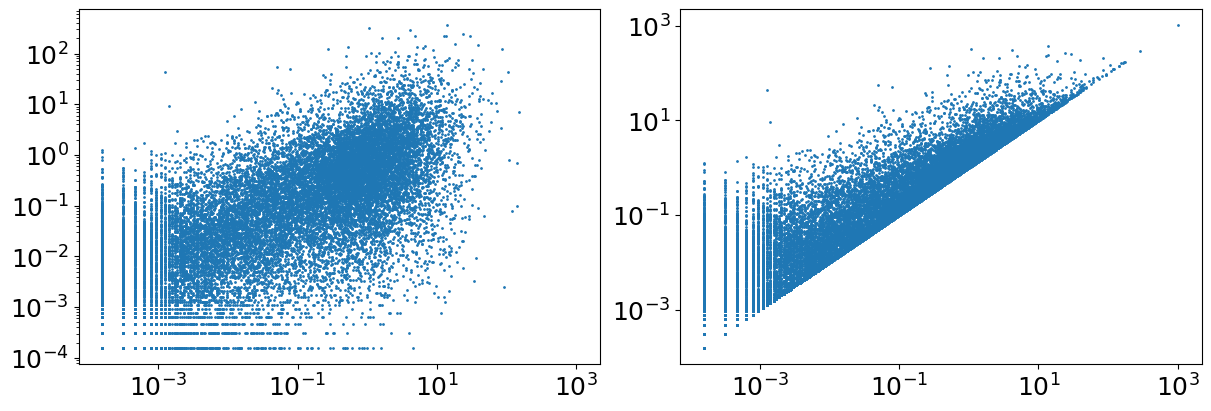

In [12]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(adata.layers['spliced'].toarray().mean(0),adata.layers['unspliced'].toarray().mean(0),s=1)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].scatter(adata.layers['spliced'].toarray().mean(0),adata.X.toarray().mean(0),s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
print(adata.layers['unspliced'].toarray().mean(),adata.layers['spliced'].toarray().mean())

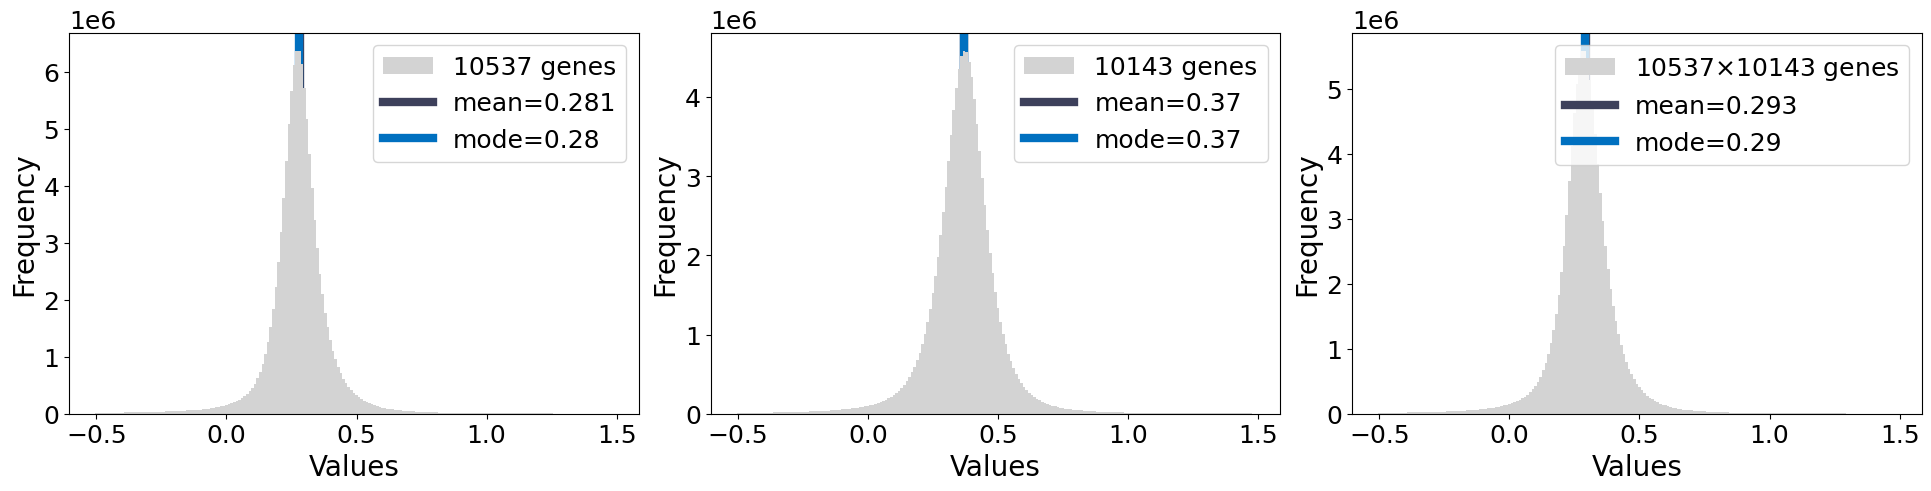

In [15]:
fig,axs = plt.subplots(1,3,figsize=(19.2,4.8))

s_mm = estimate_s(N1=adata.layers["spliced"].toarray(),ax=axs[0],min_mean=0.1)
s_nn = estimate_s(N1=adata.layers["unspliced"].toarray(),ax=axs[1],min_mean=0.1)
s_nm = estimate_s(N1=adata.layers["spliced"].toarray(),N2=adata.layers["unspliced"].toarray(),ax=axs[2],min_mean=0.1)

for i in range(len(axs)):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

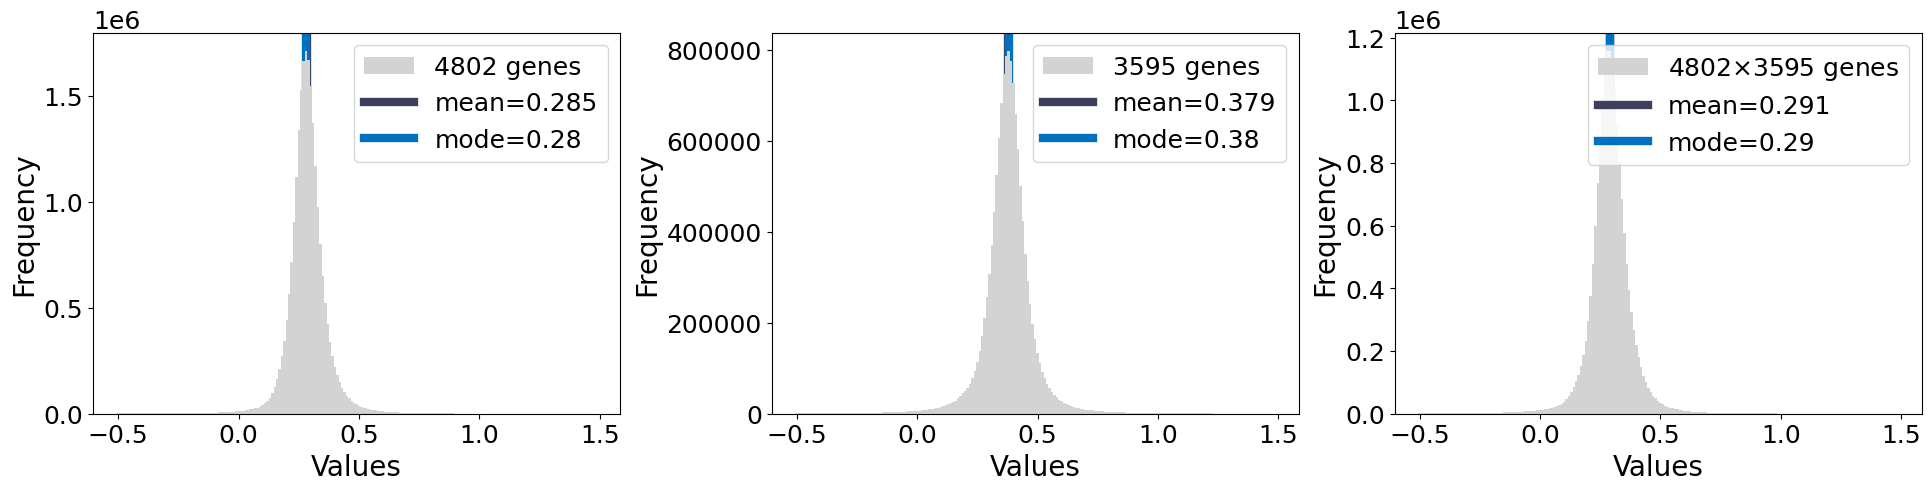

In [116]:
fig,axs = plt.subplots(1,3,figsize=(19.2,4.8))

s_mm = estimate_s(N1=adata.layers["spliced"].toarray(),ax=axs[0],min_mean=1)
s_nn = estimate_s(N1=adata.layers["unspliced"].toarray(),ax=axs[1],min_mean=1)
s_nm = estimate_s(N1=adata.layers["spliced"].toarray(),N2=adata.layers["unspliced"].toarray(),ax=axs[2],min_mean=1)

for i in range(len(axs)):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

# Selecting "Poission" genes

In [14]:
X_ = adata.layers['spliced'].toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]

lower_bound, upper_bound, eta_bootstrap = bootstrapping_func(normalized_variance,[X_],B=1000,n_cores=50)

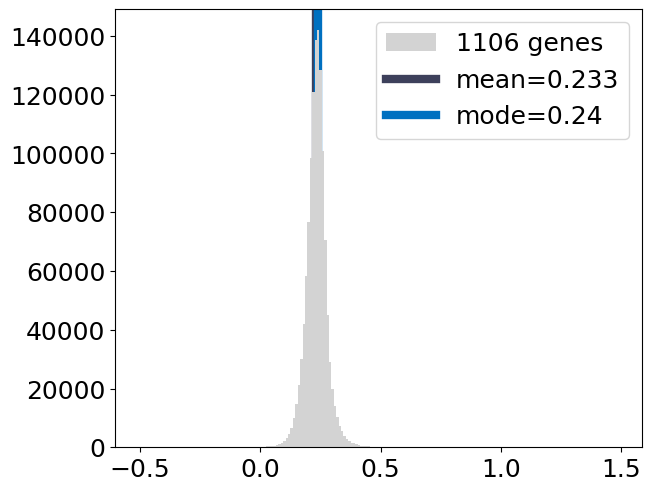

In [16]:
s_ss = 0.29
s = s_ss
S_Pgene_mask = (s < upper_bound) & (s > lower_bound) 
S_Pgene = adata.var_names[nonzero_idx][S_Pgene_mask]

fig,axs = plt.subplots(1,1)

idx = adata.var_names.isin(S_Pgene)
X_S = adata.layers['spliced'].toarray()[:,idx]
s = estimate_s(X_S,ax=axs)

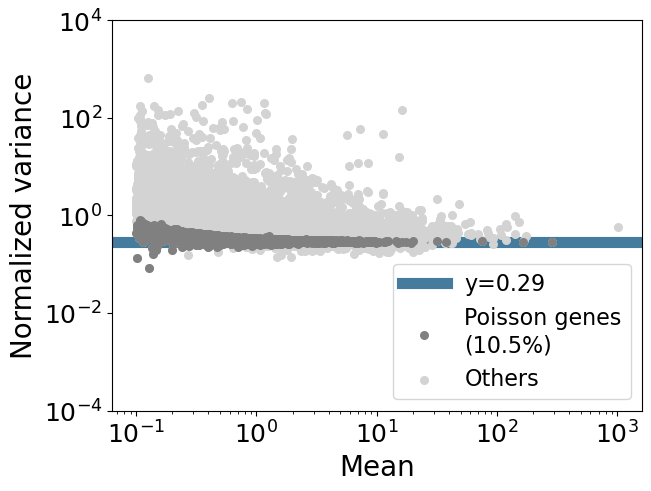

In [17]:
s = s_ss
X_ = adata.layers['spliced'].toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)
Pgene_mask = S_Pgene_mask.copy()

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.axhline(y=s, linestyle='-', color='#457b9d', linewidth=8, zorder=0, label="y="+str(np.around(s,3)))
ax.scatter(X_mean[Pgene_mask], (X_var[Pgene_mask]-X_mean[Pgene_mask])/X_mean[Pgene_mask]**2, s=30, alpha=1, zorder=2, c='gray', \
           label='Poisson genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax.scatter(X_mean, (X_var-X_mean)/X_mean**2,c='lightgray',alpha=1, s=30, zorder=1, label='Others')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-4,1e4])
ax.set_xlabel('Mean',fontsize=20);
ax.set_ylabel('Normalized variance',fontsize=20);
ax.legend(loc='lower right',fontsize=16);

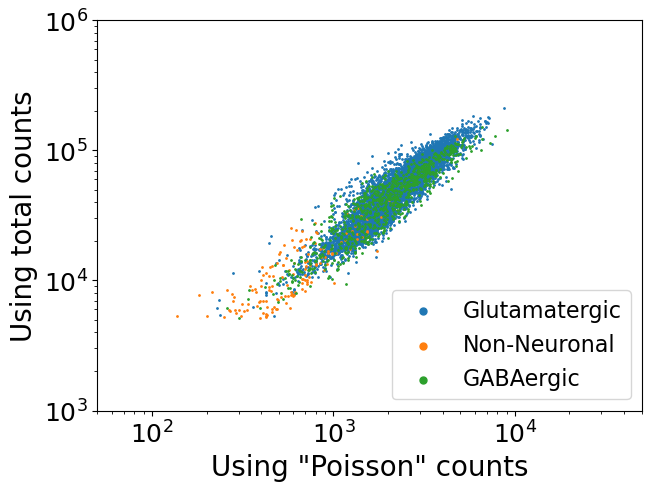

In [27]:
# Preprocessing
X_ = adata.layers["spliced"].toarray().copy()
nonzero_idx = X_.mean(0) > 0.1
X_ = X_[:, nonzero_idx]
cellsize_S = X_[:, S_Pgene_mask].sum(1)
cellsize_X = adata.X.toarray().copy().sum(1)

# Extract class labels
class_labels = adata.obs["class_label"]

# Map unique labels to distinct colors
unique_labels = class_labels.unique()
color_map = dict(zip(unique_labels, plt.cm.tab10.colors[:len(unique_labels)]))  # Choose a colormap

# Plot
fig, ax = plt.subplots(1, 1, figsize=(6.4, 4.8))
for label in unique_labels:
    idx = class_labels == label
    ax.scatter(
        cellsize_S[idx], 
        cellsize_X[idx], 
        s=1, 
        color=color_map[label], 
        label=label
    )
 
ax.set_ylim((1e3,1e6))
ax.set_xlim((5e1,5e4))

# Set log-log scale
ax.set_xscale('log')
ax.set_yscale('log')

# Add legend and labels
plt.legend(loc="lower right", markerscale=5, fontsize=16)
plt.xlabel('Using "Poisson" counts', fontsize=20)
plt.ylabel('Using total counts', fontsize=20)
plt.show()

# Check covariance relationships

In [1]:
idx = (adata.layers["unspliced"].toarray().mean(0) > 0.1) & (adata.layers["spliced"].toarray().mean(0) > 0.1) 

U = adata.layers["unspliced"][:,idx].toarray()
S = adata.layers["spliced"][:,idx].toarray()
A = adata.layers["ambiguous"][:,idx].toarray()

S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)

S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

zeta_uu = (U_var-U_mean)/U_mean**2
zeta_ss = (S_var-S_mean)/S_mean**2

cov_us = []
for i in np.arange(len(U_mean)):
    cov_us.append(np.cov(U[:,i],S[:,i])[0,1])
cov_us = np.array(cov_us)
zeta_us = (cov_us)/S_mean/U_mean
zeta_us.shape

NameError: name 'adata' is not defined

## Var(N_U)

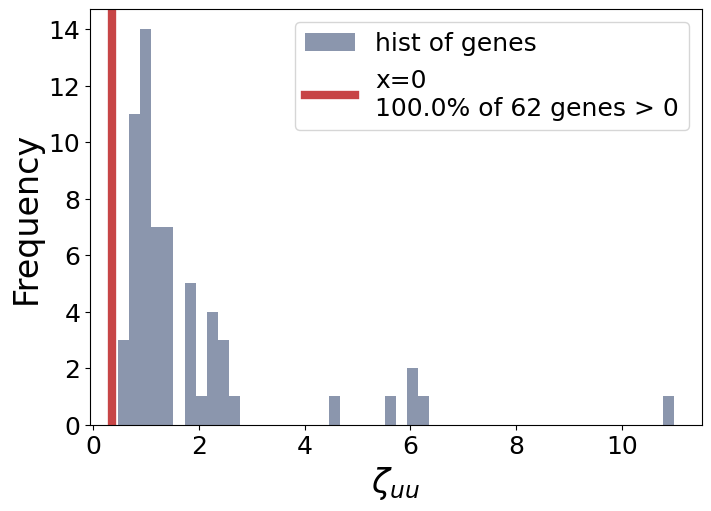

In [63]:
plt.figure(figsize=(7,5))
plt.hist(zeta_uu,bins=50,color=gray,label='hist of genes');
#plt.text(1.5, 300, str(np.around(100*(zeta_uu>0).mean(),2))+'% of '+str(len(zeta_uu))+' genes > 0', color='k')
plt.axvline(x=ss,c=red,label='x=0\n'+str(np.around(100*np.array(zeta_uu>ss).mean(),2))+'% of '+str(len(zeta_uu))+' genes > 0')
plt.xlabel(r'$\zeta_{uu}$',fontsize=label_font)
plt.ylabel('Frequency',fontsize=label_font)
plt.legend();
plt.savefig(figprefix+"_uu.pdf", dpi=150)

## Cov(N_u,N_s)
$$\zeta_{us}<\zeta_{uu}$$

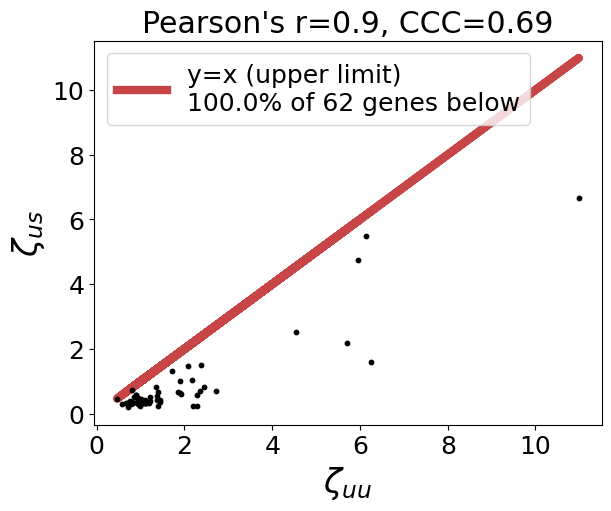

In [64]:
x=zeta_uu
y=zeta_us

plt.figure(figsize=(6,5))
plt.plot(x,x,zorder=0,c=red, \
         label='y=x (upper limit)\n' \
         +str(np.around(100*(x>y).mean(),2))+'% of '+str(len(zeta_uu))+' genes below')
#plt.text(0, 5, str(np.around(100*(x>y).mean(),2))+'% of '+str(len(zeta_uu))+r' genes $\zeta_{uu}>\zeta_{us}$', color='k')
#plt.plot(x,x/2,zorder=0,label='y=0.5x (beta=gamma))\n'+str(np.around(100*(x>=2*y).mean(),2))+'% of cells y<=0.5x')
plt.scatter(x,y,s=10,color=dark)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
#plt.colorbar(label='1/mean')
plt.legend()
plt.xlabel(r'$\zeta_{uu}$',fontsize=label_font)
plt.ylabel(r'$\zeta_{us}$',fontsize=label_font)
plt.savefig(figprefix+"_us.pdf", dpi=150)

## Var(N_s)

$$\zeta_{ss}=\zeta_{us}$$

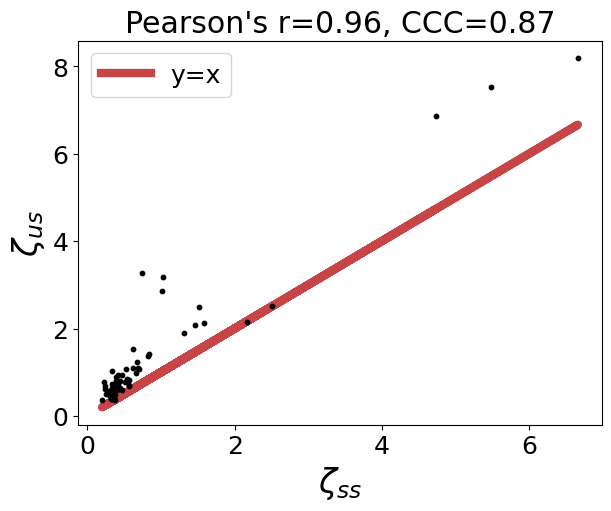

In [65]:
x=zeta_us
y=zeta_ss

plt.figure(figsize=(6,5))
plt.plot(x,x,zorder=0,label='y=x',c=red)
plt.scatter(x,y,s=10,color=dark)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
#plt.colorbar(label=r'1/E[$N_s$]')
#plt.text(1, 2, "CCC = "+str(np.round(CCC(x,y),2)), fontsize=24, color='k')
plt.legend()
plt.xlabel(r'$\zeta_{ss}$',fontsize=label_font)
plt.ylabel(r'$\zeta_{us}$',fontsize=label_font)
plt.savefig(figprefix+"_ss.pdf", dpi=150)

# Check protein varaince

In [71]:
U = adata.layers["unspliced"].toarray()[:,protein_gene_rna_idx]
S = adata.layers["spliced"].toarray()[:,protein_gene_rna_idx]
P = protein.X
U.shape, P.shape

((4709, 11), (4709, 11))

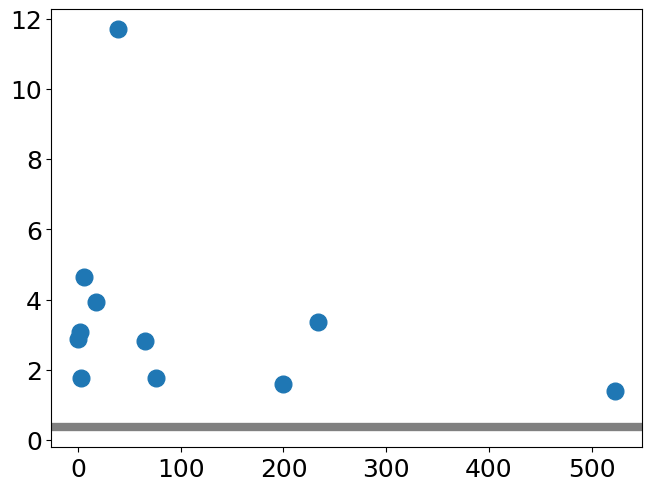

In [67]:
plt.scatter(P.mean(0),(P.var(0)-P.mean(0))/P.mean(0)**2)
plt.axhline(y=ss,color='gray',zorder=0)

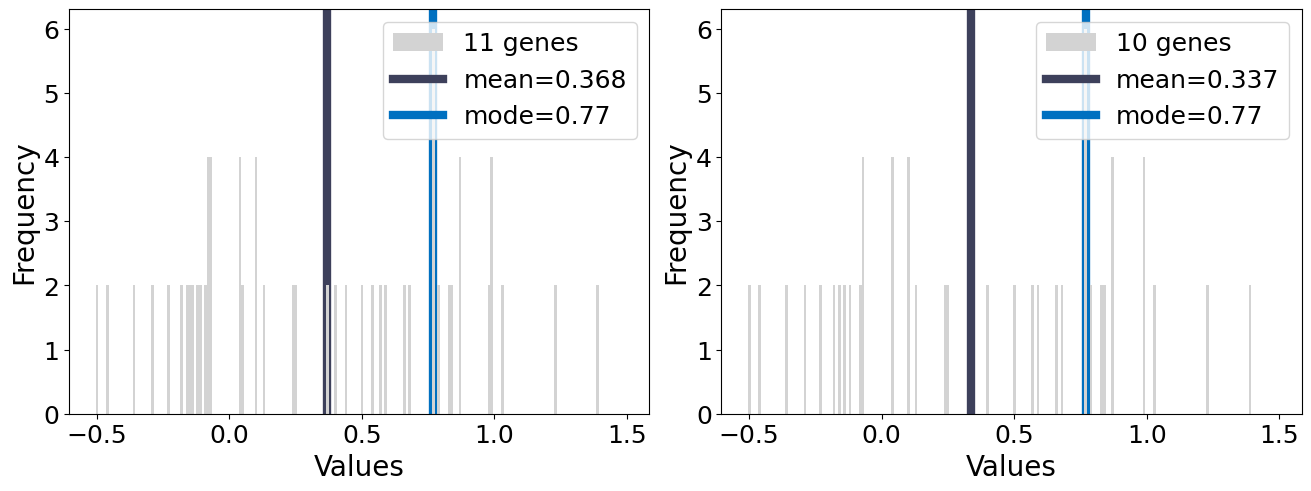

In [70]:
fig,axs = plt.subplots(1,2,figsize=(13,4.8))

s_mm = estimate_s(N1=P,ax=axs[0],min_mean=0)
s_nn = estimate_s(N1=P,ax=axs[1],min_mean=1)

for i in range(2):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

In [72]:
iidx = (np.mean(P,axis=0)>1) & (np.mean(S,axis=0)>0.1)
U = U[:,iidx]
S = S[:,iidx]
P = P[:,iidx]

S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)
P_mean = np.mean(P,axis=0)
P_var = np.var(P,axis=0)
S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

zeta_pp = (P_var-P_mean)/P_mean**2
zeta_uu = (U_var-U_mean)/U_mean**2
zeta_ss = (S_var-S_mean)/S_mean**2

cov_us = []
cov_up = []
cov_sp = []
for i in range(len(U_mean)):
    cov_us.append(np.cov(U[:,i],S[:,i])[0,1])
    cov_up.append(np.cov(U[:,i],P[:,i])[0,1])
    cov_sp.append(np.cov(S[:,i],P[:,i])[0,1])
    
zeta_us = (np.array(cov_us)/U_mean/S_mean)
zeta_up = (np.array(cov_up)/U_mean/P_mean)
zeta_sp = (np.array(cov_sp)/S_mean/P_mean)
zeta_us

array([1.76176314, 3.66018575])

## $Cov(N_u,N_p)$ 
$$ \gamma_p \zeta_{us} = (\gamma_p + \beta) \zeta_{up} $$  

In [48]:
zeta_up,zeta_us

(ArrayView([ 3.06162100e-01,  2.25448604e+00,  1.08163922e+01,
             1.06259800e+00,  1.45303673e+00, -2.35870933e-02,
             1.78594057e+00,  1.04808170e-03,  3.43266354e+00]),
 array([ 1.49431484, -1.00021241,  8.96804248, -0.29406546,  1.28060123,
         1.76176314,  3.66018575, -1.00021239,  5.64696517]))

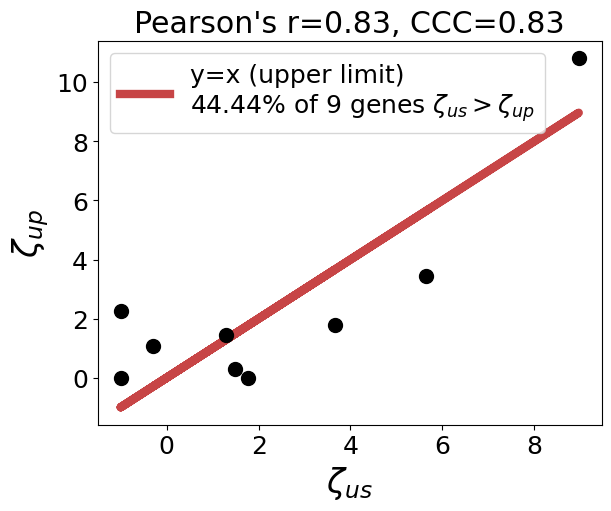

In [49]:
x=zeta_us
y=zeta_up

plt.figure(figsize=(6,5))
plt.plot(x,x,zorder=0,c=red, \
         label='y=x (upper limit)\n'+str(np.around(100*(x>y).mean(),2))+'% of '+str(len(zeta_uu))+r' genes $\zeta_{us}>\zeta_{up}$')
#plt.text(0, 10, str(np.around(100*(x>y).mean(),2))+'% of '+str(len(zeta_uu))+r' genes $\zeta_{uu}>\zeta_{us}$', color='k')
#plt.plot(x,x/2,zorder=0,label='y=0.5x (beta=gamma))\n'+str(np.around(100*(x>=2*y).mean(),2))+'% of cells y<=0.5x')
plt.scatter(x,y,s=100,color=dark)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
#plt.colorbar(label='1/mean')
plt.legend(loc='upper left')
plt.xlabel(r'$\zeta_{us}$',fontsize=label_font)
plt.ylabel(r'$\zeta_{up}$',fontsize=label_font)
plt.savefig(figprefix+"_up.pdf", dpi=150)

## $Cov(N_s,N_p)$ 

$$\gamma (\zeta_{up}-\zeta_{sp}) + \gamma_p (\zeta_{ss}-\zeta_{sp}) = -\frac{\gamma_p}{\overline{X_s}} $$

In [50]:
zeta_up-zeta_sp,(zeta_ss-zeta_sp)

(ArrayView([-0.06353612, -0.72899622, -1.26730619, -0.12312637,
             0.3323472 ,  0.00808817, -0.16114041, -1.47973893,
            -0.27331627]),
 ArrayView([-1.36968821, -3.98364152,  3.19432912,  1.39781582,
             8.06313214,  2.54802171,  2.05792486, -2.48086569,
            12.95279362]))

/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/numpy/core/function_base.py:170: ImplicitModificationWarning: Trying to modify attribute `.X` of view, initializing view as actual.
  y[-1] = stop
/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/numpy/lib/histograms.py:840: ImplicitModificationWarning: Trying to modify attribute `.X` of view, initializing view as actual.
  indices[indices == n_equal_bins] -= 1


IndexError: boolean index did not match indexed array along dimension 0; dimension is 4709 but corresponding boolean dimension is 9

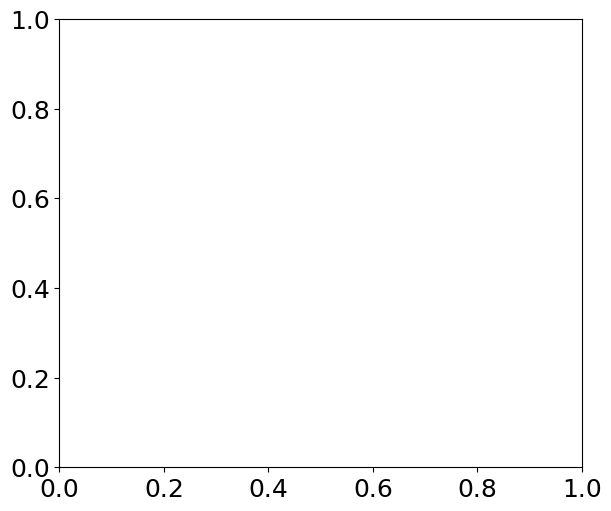

In [51]:
x = np.minimum(zeta_up-zeta_sp,zeta_ss-zeta_sp)

plt.figure(figsize=(6,5))
plt.hist(x,bins=50,color=gray,\
         label='hist of genes\n' + str(np.around(100*(x<0).mean(),2))+'% of '+str(len(zeta_uu))+' genes < 0')
plt.axvline(x=0,c=red,label='x=0')
plt.xlabel(r'$\zeta_{uu}$',fontsize=label_font)
plt.ylabel('Frequency',fontsize=label_font)
plt.legend();
plt.savefig(figprefix+"_sp.pdf", dpi=150)

## $Var(N_p)$ 
$$ \zeta_{sp} = \zeta_{pp} $$  

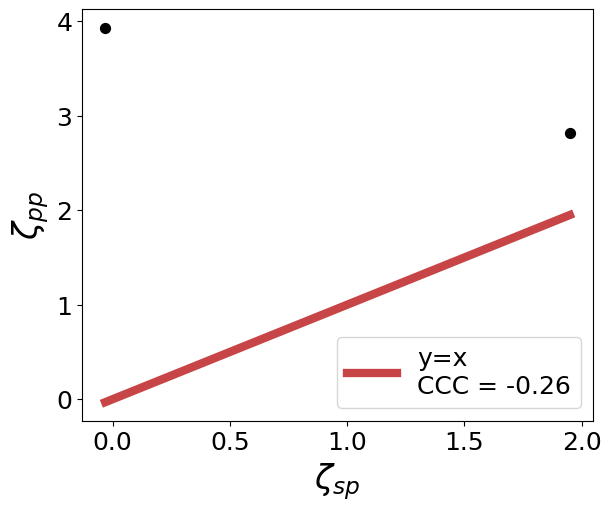

In [73]:
idx = (np.mean(S,axis=0)>0.0) &  (np.mean(P,axis=0)>0)
x=zeta_sp[idx]
y=zeta_pp[idx]

plt.figure(figsize=(6,5))
plt.plot(x,x,zorder=0,label='y=x\n'+"CCC = "+str(np.round(CCC(x,y),2)),c=red)
plt.scatter(x,y,s=50,color=dark)
#plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
#plt.colorbar(label=r'1/E[$N_s$]')
#plt.text(1, 1, "CCC = "+str(np.round(CCC(x,y),2)), fontsize=24, color='k')
#plt.text(1, 15, "ICC(2,1) = "+str(np.round(ICC(x,y),2)), fontsize=24, color='k')
plt.legend(loc='lower right')
plt.xlabel(r'$\zeta_{sp}$',fontsize=label_font)
plt.ylabel(r'$\zeta_{pp}$',fontsize=label_font)
plt.savefig(figprefix+"_pp.pdf", dpi=150)